In [1]:
#@title Setup project root

PROJECT_ROOT = "/Users/yunfanbao/Documents/work/mv-mammo-transformer"

import os, sys

os.chdir(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)

print("Current directory:", os.getcwd())

Current directory: /Users/yunfanbao/Documents/work/mv-mammo-transformer


In [2]:
#@title Load CSVs

from src.data.breast_level import BreastLevel
from src.data.metadata import Metadata
from src.data.status import Status

breast_level = BreastLevel()
metadata = Metadata()
status = Status()

print("Loaded breast_level, metadata, status")

Loaded breast_level, metadata, status


In [3]:
#@title Dataset Size

print("Total studies:", len(breast_level.by_study_id.get_all()))
print("Total images:", len(breast_level.by_image_id.get_all()))

Total studies: 5000
Total images: 20000


In [4]:
#@title Study Completeness

broken = []

for study_id, entries in breast_level.by_study_id.get_all().items():
    if len(entries) != 4:
        broken.append((study_id, len(entries)))

len(broken), broken[:5]

(0, [])

In [5]:
#@title **BI-RADS** Distribution (Image-level)

from collections import Counter

birads = []

for study_id in breast_level.by_study_id.get_all().keys():
    birads_map = breast_level.by_study_id.get_breast_birads(study_id)
    for v in birads_map.values():
        birads.append(v)

counter = Counter(sorted(birads))
counter

Counter({'BI-RADS 1': 6703,
         'BI-RADS 2': 2338,
         'BI-RADS 3': 465,
         'BI-RADS 4': 381,
         'BI-RADS 5': 113})

In [6]:
#@title **BI-RADS** Distribution (Study-level, MAX rule)

birads = []

for study_id in breast_level.by_study_id.get_all().keys():
    birads_map = breast_level.by_study_id.get_breast_birads(study_id)
    max_birads = max(
        birads_map.values(),
        key=lambda x: int(x.split()[-1])
    )
    birads.append(max_birads)

counter = Counter(sorted(birads))
counter

Counter({'BI-RADS 1': 2515,
         'BI-RADS 2': 1568,
         'BI-RADS 3': 436,
         'BI-RADS 4': 368,
         'BI-RADS 5': 113})

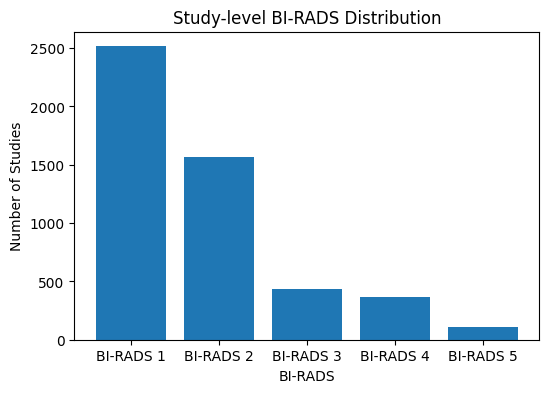

In [7]:
#@title Plot **BI-RADS** Distribution (Study-level, MAX rule)

import matplotlib.pyplot as plt

labels = sorted(counter.keys())
values = [counter[l] for l in labels]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.xlabel("BI-RADS")
plt.ylabel("Number of Studies")
plt.title("Study-level BI-RADS Distribution")
plt.show();

In [8]:
#@title **Density** Distribution (Image-level)

density = []

for study_id in breast_level.by_study_id.get_all().keys():
    density_map = breast_level.by_study_id.get_breast_density(study_id)
    for v in density_map.values():
        density.append(v)

counter = Counter(sorted(density))
counter

Counter({'DENSITY C': 7646,
         'DENSITY D': 1350,
         'DENSITY B': 954,
         'DENSITY A': 50})

In [9]:
#@title **Density** Distribution (Study-level, MAX rule)

density = []

for study_id in breast_level.by_study_id.get_all().keys():
    density_map = breast_level.by_study_id.get_breast_density(study_id)
    max_density = max(
        density_map.values(),
        key=lambda x: str(x.split()[-1])
    )
    density.append(max_density)

counter = Counter(sorted(density))
counter

Counter({'DENSITY C': 3826,
         'DENSITY D': 681,
         'DENSITY B': 469,
         'DENSITY A': 24})

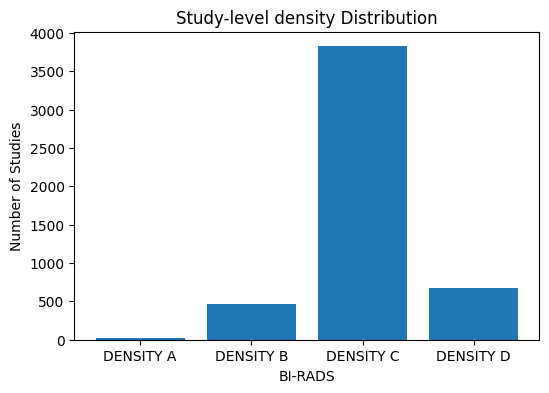

In [10]:
#@title Plot **Density** Distribution (Study-level, MAX rule)

labels = sorted(counter.keys())
values = [counter[l] for l in labels]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.xlabel("BI-RADS")
plt.ylabel("Number of Studies")
plt.title("Study-level density Distribution")
plt.show();

In [11]:
#@ Full Dataset Split Overview

DATA_VERSION = "full"

split_map = status.get_split(DATA_VERSION)

{k: len(v) for k, v in split_map.items()}

{'F1': 3200, 'F2': 3200, 'F3': 3200, 'F4': 3200, 'F5': 3200, 'test': 4000}

In [12]:
#@title Fold-wise **BI-RADS** Balance Check

def fold_birads_distribution(split_name):
    rows = split_map[split_name]
    birads = []

    for r in rows:
        b = breast_level.by_study_id.get_breast_birads(r["study_id"])
        max_birads = max(
            b.values(),
            key=lambda x: int(x.split()[-1])
        )
        birads.append(max_birads)

    return Counter(birads)

for fold in ["F1", "F2", "F3", "F4", "F5"]:
    print(fold, fold_birads_distribution(fold))

F1 Counter({'BI-RADS 1': 1616, 'BI-RADS 2': 1000, 'BI-RADS 3': 276, 'BI-RADS 4': 236, 'BI-RADS 5': 72})
F2 Counter({'BI-RADS 1': 1616, 'BI-RADS 2': 1000, 'BI-RADS 3': 276, 'BI-RADS 4': 236, 'BI-RADS 5': 72})
F3 Counter({'BI-RADS 1': 1616, 'BI-RADS 2': 1000, 'BI-RADS 3': 276, 'BI-RADS 4': 236, 'BI-RADS 5': 72})
F4 Counter({'BI-RADS 1': 1616, 'BI-RADS 2': 1000, 'BI-RADS 3': 276, 'BI-RADS 4': 236, 'BI-RADS 5': 72})
F5 Counter({'BI-RADS 1': 1620, 'BI-RADS 2': 996, 'BI-RADS 3': 276, 'BI-RADS 4': 236, 'BI-RADS 5': 72})


In [13]:
#@title Fold-wise **Density** Balance Check

def fold_density_distribution(split_name):
    rows = split_map[split_name]
    density = []

    for r in rows:
        b = breast_level.by_study_id.get_breast_density(r["study_id"])
        max_density = max(
            b.values(),
            key=lambda x: str(x.split()[-1])
        )
        density.append(max_density)

    return Counter(density)

for fold in ["F1", "F2", "F3", "F4", "F5"]:
    print(fold, fold_density_distribution(fold))

F1 Counter({'DENSITY C': 2448, 'DENSITY D': 416, 'DENSITY B': 324, 'DENSITY A': 12})
F2 Counter({'DENSITY C': 2492, 'DENSITY D': 404, 'DENSITY B': 288, 'DENSITY A': 16})
F3 Counter({'DENSITY C': 2456, 'DENSITY D': 408, 'DENSITY B': 320, 'DENSITY A': 16})
F4 Counter({'DENSITY C': 2412, 'DENSITY D': 464, 'DENSITY B': 304, 'DENSITY A': 20})
F5 Counter({'DENSITY C': 2432, 'DENSITY D': 488, 'DENSITY B': 264, 'DENSITY A': 16})
